In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python


farshed.abdukhakimov
cn-02
/home/farshed.abdukhakimov/projects/sania


In [2]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

import scipy
# import optuna
import neptune 

import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

/home/farshed.abdukhakimov/miniconda3/envs/main/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


True

In [28]:
import scipy.sparse


dataset_name = "sonar_scale"
train_data, train_target, test_data, test_target = utils.get_libsvm(name=dataset_name, test_split=0.2)

scale = 4    
scaling_vec = utils.generate_scaling_vec(size=train_data.shape[1], scale=scale)
if scipy.sparse.issparse(train_data):
    scaled_train_data = train_data.multiply(scaling_vec).tocsr()
    scaled_test_data = test_data.multiply(scaling_vec).tocsr()
else:
    scaled_train_data = scaling_vec * train_data
    scaled_test_data = scaling_vec * test_data

train_dataset = train_data, train_target
test_dataset =  test_data, test_target

scaled_train_dataset = scaled_train_data, train_target
scaled_test_dataset = scaled_test_data, test_target

print(train_data.shape, test_data.shape)
print("Sparsity: ", 1 - (train_data.count_nonzero() / (train_data.shape[0] * train_data.shape[1])))

(208, 60) (208, 60)
Sparsity:  8.012820512826035e-05


In [29]:
def train_loop(seed: int, train_dataset: list, test_dataset: list, batch_size: int, n_epochs: int,
               optimizer: BaseOptimizer, lmd: float, **optimizer_kwargs) -> dict: 
    
    np.random.seed(seed)
    
    train_data, train_target = train_dataset
    test_data, test_target = test_dataset
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params=params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=lmd)
    
    # e.g. libsvm dataset has {0.0, 1.0} classes that cannot be used for LogisticRegressionLoss 
    # hence they will be remapped to {-1.0, 1.0}        
    if isinstance(loss_function, LogisticRegressionLoss):
        if not np.array_equal(np.unique(train_target), (-1.0, 1.0)):
            train_target = utils.map_classes_to(train_target, (-1.0, 1.0))
            test_target = utils.map_classes_to(test_target, (-1.0, 1.0))
    
    assert np.array_equal(np.unique(train_target), (-1.0, 1.0))
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Testing 
        test_loss, test_grad, test_acc = loss_function.func_grad_acc(params, test_data, test_target)
        test_g_norm = np.linalg.norm(test_grad)**2
        history["test/loss"].append(test_loss)
        history["test/acc"].append(test_acc)
        history["test/grad_norm"].append(test_g_norm)
        

        # Training 
        np.random.shuffle(indices)

        train_epoch_loss = 0.0
        train_epoch_acc = 0.0
        train_epoch_grad_norm = 0.0
        
        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            g_norm = np.linalg.norm(train_grad)**2
            
            optim.step(loss=train_loss, grad=train_grad)

            train_epoch_loss += train_loss
            train_epoch_acc += train_acc
            train_epoch_grad_norm += g_norm
            
            history["train/batch/loss"].append(train_loss)
            history["train/batch/acc"].append(train_acc)
            history["train/batch/grad_norm"].append(g_norm)
            
            
        train_epoch_loss = train_epoch_loss / (idx + 1)
        train_epoch_acc = train_epoch_acc / (idx + 1)
        train_epoch_grad_norm = train_epoch_grad_norm / (idx + 1)
        
        history["train/epoch/loss"].append(train_epoch_loss)
        history["train/epoch/acc"].append(train_epoch_acc)
        history["train/epoch/grad_norm"].append(train_epoch_grad_norm)

        
        # print(f"Epoch [{epoch}/{n_epochs}] | Train Loss: {epoch_loss} | Val Loss: {val_loss}")
        # print(f"Val GradNorm**2: {val_g_norm} | Train GradNorm**2: {epoch_grad_norm}")
        # print(f"Val Acc: {val_acc} | Train Acc: {epoch_acc}\n")
        
        
    # Testing 
    test_loss, test_grad, test_acc = loss_function.func_grad_acc(params, test_data, test_target)
    test_g_norm = np.linalg.norm(test_grad)**2
    history["test/loss"].append(test_loss)
    history["test/acc"].append(test_acc)
    history["test/grad_norm"].append(test_g_norm)
    
    history["params"].append(params)
    
    # print(f"Test Loss: {test_loss} | Test Acc: {test_acc} | Test GradNorm**2: {test_g_norm}")
    
    return history

In [30]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, prefix="val", suptitle=None, 
            threshold=1e-10, max_iters=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
        
    if max_iters is None:
        max_iters = np.max([len(x[f"{prefix}/loss"]) for x in histories])
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        f_suboptim = history[f"{prefix}/loss"]
        # f_suboptim[f_suboptim < threshold] = 0.0
        
        markevery = [x + np.random.randint(0, 3) for x in range(0, len(history[f"{prefix}/loss"]), len(history[f"{prefix}/loss"]) // 10)]
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[1].plot(history[f"{prefix}/acc"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)

    ax[0].set_ylabel(r"$f(w_i)$")
    ax[1].set_ylabel("Accuracy")
        
    # ax[1].set_ylim(bottom=0.75)
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show() 

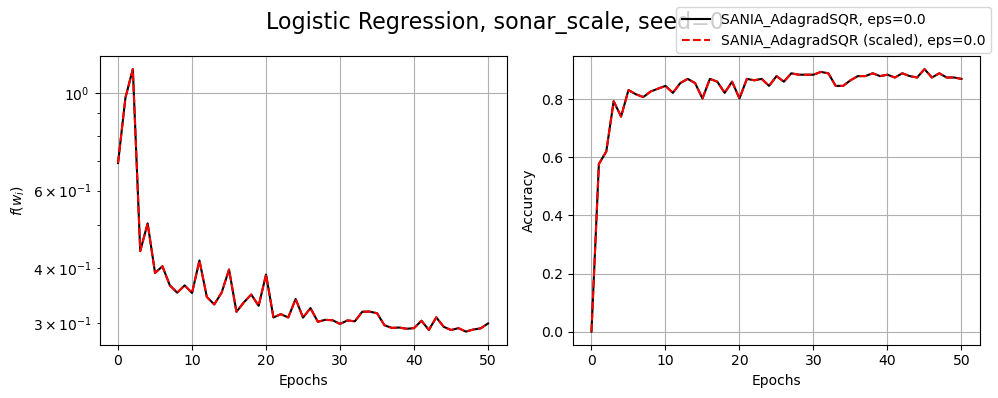

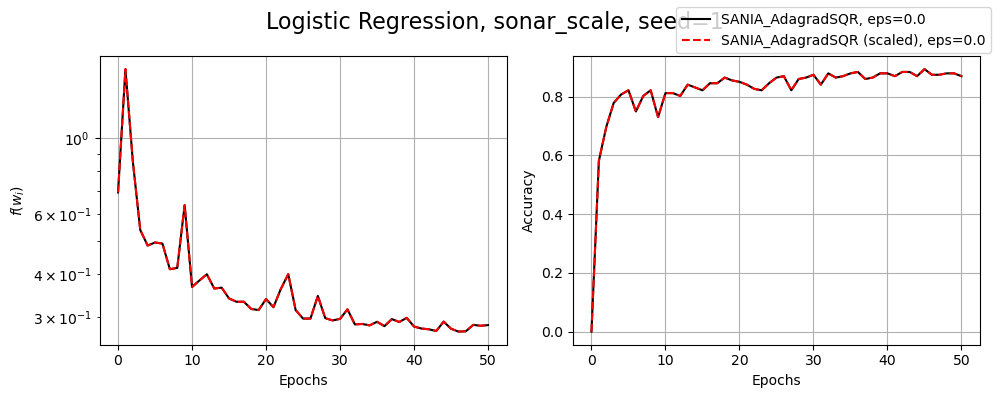

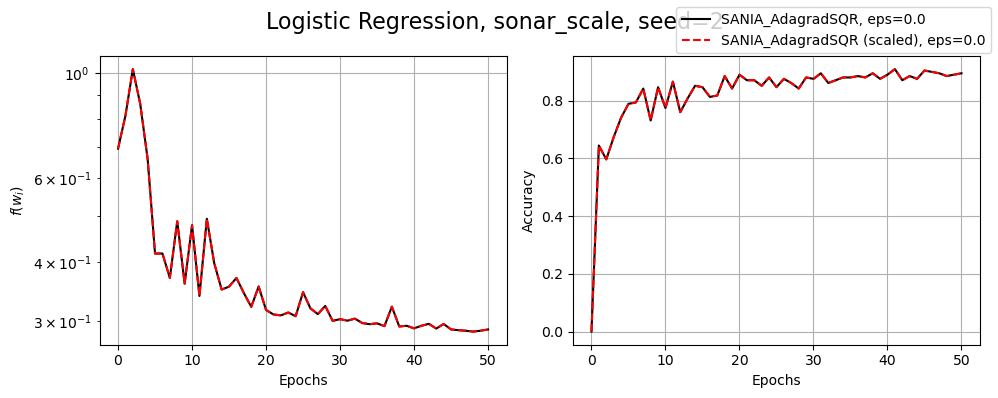

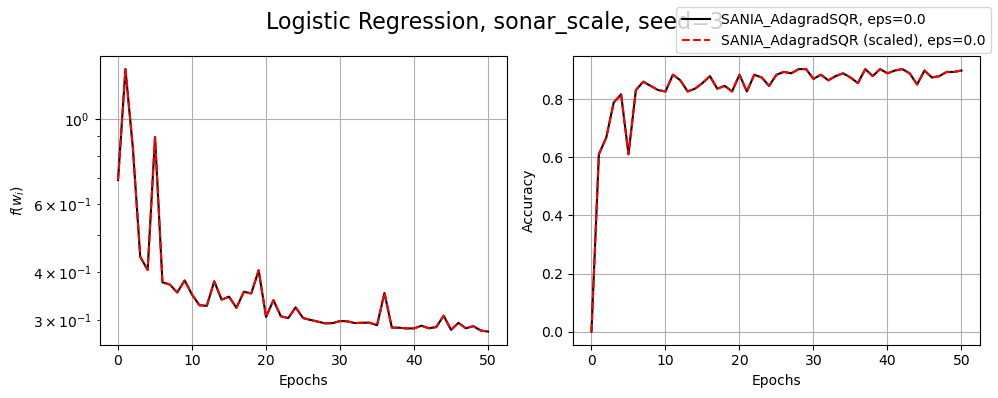

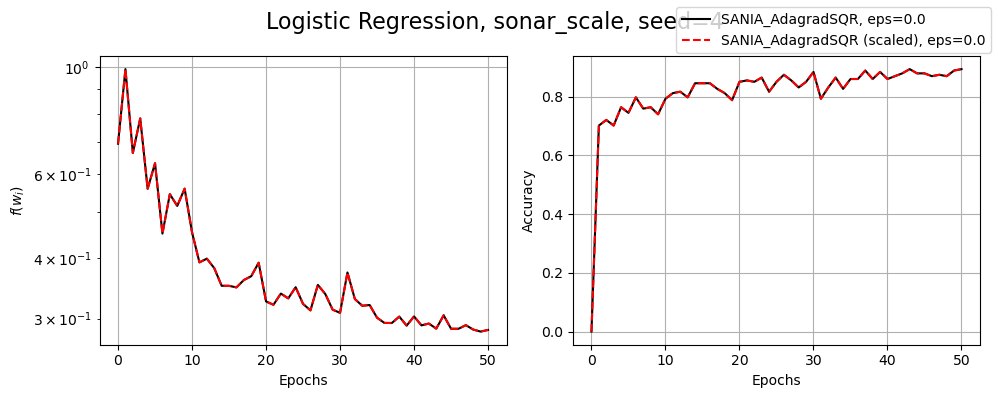

In [55]:
n_epochs = 50

batch_size = 16
seed = 0
lmd = 0.0

for seed in range(5):

    histories = []
    labels = []

    optimizer = SANIA_AdagradSQR
    eps = 0.0
    hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer,
                    lmd=lmd, eps=eps)
    histories.append(hist)
    labels.append(f"{optimizer.__name__}, {eps=}")

    optimizer = SANIA_AdagradSQR
    eps = 0.0
    hist = train_loop(seed=seed, train_dataset=scaled_train_dataset, test_dataset=scaled_test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer, 
                    lmd=lmd, eps=eps)
    histories.append(hist)
    labels.append(f"{optimizer.__name__} (scaled), {eps=}")

    plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "blue", "purple", "teal", "lime"],
        linestyles=["-", "--", "-", "--", "-", "--"],
        prefix="test",
        suptitle=f"Logistic Regression, {dataset_name}, seed={seed}",
        )

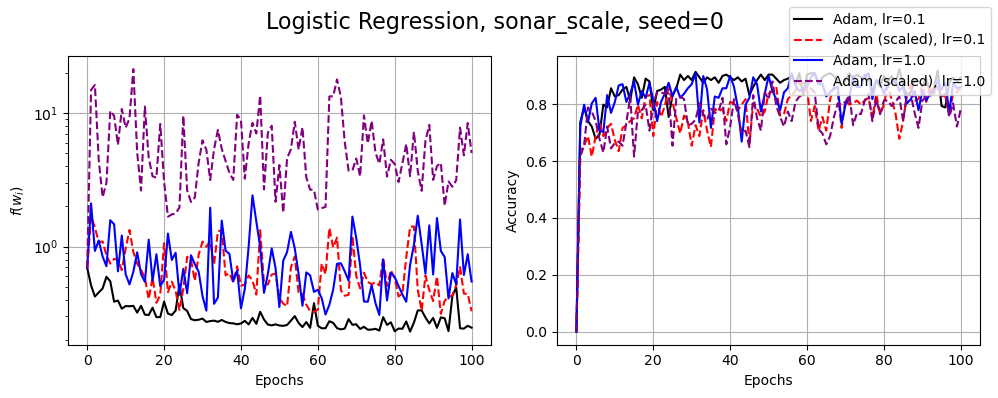

In [56]:
seed = 0
n_epochs = 100

histories = []
labels = []

for lr in  [0.1, 1.0]:

    optimizer = Adam
    hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer,
                    lmd=lmd, lr=lr)
    histories.append(hist)
    labels.append(f"{optimizer.__name__}, {lr=}")

    hist = train_loop(seed=seed, train_dataset=scaled_train_dataset, test_dataset=scaled_test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer, 
                    lmd=lmd, lr=lr)
    histories.append(hist)
    labels.append(f"{optimizer.__name__} (scaled), {lr=}")

plotter(histories=histories, 
    labels=labels,
    colors=["black", "red", "blue", "purple", "teal", "lime"],
    linestyles=["-", "--", "-", "--", "-", "--"],
    prefix="test",
    suptitle=f"Logistic Regression, {dataset_name}, seed={seed}",
    )